In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import MetaTrader5 as mt5

In [2]:
def f_init_login(param_acc, param_pass, param_exe):
    """
    Initialize conexion and Login into a Meta Trader 5 account in the local computer where this code is executed, using the MetaTrader5 python package.
    Parameters
    ----------
    param_acc: int
        accout number used to login into MetaTrader5 Web/Desktop App (normally is a 8-9 digit integer number)
        param_acc = 41668916
    param_pass: str
        accout trader's password (or just password) to login into MetaTrader5 Web/Desktop App 
        (normally alphanumeric include uppercase and sometimes symbols). If the investor's password 
        is provided, the some actions do not work like open trades.
        param_pass = "n2eunlnt"
    
    param_direxe: str
        Route in disk where is the executable file of the MetaTrader5 desktop app which will be used 
        param_direxe = 'C:\\Program Files\\MetaTrader 5\\terminal64.exe'
    
    Return
    ------
        if connection is succesful then returns connected client object and prints message,
        if connection is not succesful then returns error message and attempts a shutdown of connection.
    
    References
    ----------
    https://www.mql5.com/en/docs/integration/python_metatrader5/mt5login_py
    
    
    """
    
    # server name (as it is specified in the terminal)
    mt5_ser = "FxPro-MT5"
    # timeout (in miliseconds)
    mt5_tmo = 10000

    # Perform initialization handshake
    ini_message = mt5.initialize(param_exe, login=param_acc, password=param_pass, server=mt5_ser,
                                 timeout=mt5_tmo, portable=False)

    # resulting message
    if not ini_message:
        print(" **** init_login failed, error code =", mt5.last_error())
        mt5.shutdown()
    else: 
        print(" ++++ init_login succeded, message = ", ini_message)
    
    # returns an instance of a connection object (or client)
    return mt5

In [3]:
def f_acc_info(param_ct):
    """
    Get the info of the account associated with the initialized client param_ct
    Params
    ------
    param_ct: MetaTrader5 initialized client object
        this is an already succesfully initialized conexion object to MetaTrader5 Desktop App
    Returns
    -------
    df_acc_info: pd.DataFrame 
        Pandas DataFrame with the account info         
    References
    ----------
    https://www.mql5.com/en/docs/integration/python_metatrader5/mt5login_py
    """

    # get the account info and transform it into a dataframe format
    acc_info = param_ct.account_info()._asdict()
    
    # select especific info to display
    df_acc_info = pd.DataFrame(list(acc_info.items()), columns=['property','value'])

    # return dataframe with the account info
    return df_acc_info

In [4]:
def f_hist_trades(param_ct, param_ini, param_end):
    """
    Get the historical executed trades in the account associated with the initialized MetaTrader5 client
    Params
    ------
    param_ct: MetaTrader5 initialized client object
        This is an already succesfully initialized conexion object to MetaTrader5 Desktop App
    
    param_ini: datetime
        Initial date to draw the historical trades
        
        param_ini = datetime(2021, 2, 1)
    param_end: datetime
        Final date to draw the historical trades
        
        param_end = datetime(2021, 3, 1)
    Returns
    -------
        df_hist_trades: pd.DataFrame
    References
    ----------
    https://www.mql5.com/en/docs/integration/python_metatrader5/mt5historydealsget_py
    https://www.mql5.com/en/docs/constants/tradingconstants/dealproperties  
    
    https://www.mql5.com/en/docs/integration/python_metatrader5/mt5historyordersget_py
    https://www.mql5.com/en/docs/constants/tradingconstants/orderproperties#enum_order_property_integer
    """

    # get historical info of deals in the account
    history_deals = param_ct.history_deals_get(param_ini, param_end)

    # get historical info of orders in the account
    history_orders = param_ct.history_orders_get(param_ini, param_end)

    # check for returned results
    if (len(history_orders) > 0) & (len(history_deals) > 0):
        print(" ++++ Historical orders retrive: OK")
        print(" ++++ Historical deals retrive: OK")
    else:
        print("No orders and/or deals returned")

    # historical deals of the account
    df_deals = pd.DataFrame(list(history_deals), columns=history_deals[0]._asdict().keys())
    
    # historical orders of the account
    df_orders = pd.DataFrame(list(history_orders), columns=history_orders[0]._asdict().keys())
   
    # useful columns from orders
    df_hist_trades = df_orders[['time_setup', 'symbol', 'position_id', 'type', 'volume_current',
                           'price_open', 'sl', 'tp']]

    # rename columns 
    df_hist_trades.columns = ['OpenTime', 'Symbol', 'Ticket', 'Type', 'Volume', 'OpenPrice', 'S/L', 'T/P']

    # choose only buy or sell transactions (ignore all the rest, like balance ...)
    df_hist_trades = df_hist_trades[(df_hist_trades['Type'] == 0) | (df_hist_trades['Type'] == 1)]
    df_hist_trades['OpenTime'] = pd.to_datetime(df_hist_trades['OpenTime'], unit='s')
    
    # unique values for position_id
    uni_id = df_hist_trades['Ticket'].unique()
    
    # first and last index for every unique value of position_id
    ind_opens = [df_hist_trades.index[df_hist_trades['Ticket'] == i][0] for i in uni_id]
    ind_closes = [df_hist_trades.index[df_hist_trades['Ticket'] == i][-1] for i in uni_id]
    
    # generate lists with values to add
    cts = df_hist_trades['OpenTime'].loc[ind_closes]
    cps = df_hist_trades['OpenPrice'].loc[ind_closes]

    # resize dataframe to have only the first value of every unique position_id
    df_hist_trades = df_hist_trades.loc[ind_opens]

    # add close time and close price as a column to dataframe
    df_hist_trades['CloseTime'] = cts.to_list()
    df_hist_trades['ClosePrice'] = cps.to_list()
    df_hist_trades['Profit'] = df_deals['profit'].loc[df_deals['position_id'].isin(uni_id) & 
                                                      df_deals['entry'] == 1].to_list()
  
    return df_hist_trades

In [5]:
def f_hist_prices(param_ct, param_sym, param_tf, param_ini, param_end):
    """
    Historical prices retrival from MetaTrader 5 Desktop App.
    Parameters
    ----------
    param_ct: MetaTrader5 initialized client object
        This is an already succesfully initialized conexion object to MetaTrader5 Desktop App
      
    param_sym: str
        The symbol of which the historical prices will be retrieved
        
        param_sym = 'EURUSD'
    
    param_tf: str
        The price granularity for the historical prices. Check available timeframes and nomenclatures from 
        the references. The substring 'TIMEFRAME_' is automatically added.
        
        param_tf = 'M1'
    param_ini: datetime
        Initial date to draw the historical trades
        
        param_ini = datetime(2021, 2, 1)
    param_end: datetime
        Final date to draw the historical trades
        
        param_end = datetime(2021, 3, 1)
    
    **** WARNINGS ****
    
    1.- Available History
    
        MetaTrader 5 terminal provides bars only within a history available to a user on charts. The number of # bars available to users is set in the "Max.bars in chart" parameter. So this must be done
        manually within the desktop app to which the connection is made.
    
    2.- TimeZone
        When creating the 'datetime' object, Python uses the local time zone, 
        MetaTrader 5 stores tick and bar open time in UTC time zone (without the shift).
        Data received from the MetaTrader 5 terminal has UTC time.
        Perform a validation whether if its necessary to shift time to local timezone.
    **** ******** ****
    References
    ----------
    https://www.mql5.com/en/docs/integration/python_metatrader5/mt5copyratesfrom_py#timeframe
    """


    # get hour info in UTC timezone (also GMT+0)
    hour_utc = datetime.datetime.now().utcnow().hour
    # get hour info in local timezone (your computer)
    hour_here = datetime.datetime.now().hour
    # difference (in hours) from UTC timezone
    diff_here_utc = hour_utc - hour_here
    # store the difference in hours
    tdelta = datetime.timedelta(hours=diff_here_utc)
    # granularity 
    param_tf = getattr(param_ct, 'TIMEFRAME_' + param_tf)
    # dictionary for more than 1 symbol to retrieve prices
    d_prices = {}

    # retrieve prices for every symbol in the list
    for symbol in param_sym:
        # prices retrival from MetaTrader 5 Desktop App
        prices = pd.DataFrame(param_ct.copy_rates_range(symbol, param_tf,
                                                         param_ini - tdelta,
                                                         param_end - tdelta))
        # convert to datetime 
        prices['time'] = [datetime.datetime.fromtimestamp(times) for times in prices['time']]

        # store in dict with symbol as a key
        d_prices[symbol] = prices
    
    # return historical prices
    return d_prices

In [6]:
# local direction of executable file
local_exe = 'C:\\Program Files\\MetaTrader 5\\terminal64.exe'

# account number *** USE YOURS INSTEAD ***
mt5_acc = 5386700

# account Password Traders/Investors *** USE YOURS INSTEAD ***
# mt5_trd_pas = "n2eunlnt" 
mt5_inv_pas = "RiBTM5T9"

# try initialization and login
mt5_client = f_init_login(param_acc=mt5_acc, param_pass=mt5_inv_pas, param_exe=local_exe)

 ++++ init_login succeded, message =  True


In [7]:
df_acc_info = f_acc_info(param_ct=mt5_client)

In [19]:
ini_date = datetime.datetime(2021, 6, 29, 0, 0)
end_date = datetime.datetime(2021, 6, 30, 0, 0)

# get historical prices
df_hist = f_hist_trades(param_ct=mt5_client, param_ini=ini_date, param_end=end_date)

 ++++ Historical orders retrive: OK
 ++++ Historical deals retrive: OK


In [21]:
df_hist

,OpenTime,Symbol,Ticket,Type,Volume,OpenPrice,S/L,T/P,CloseTime,ClosePrice,Profit
0,2021-06-30 02:19:41,EURUSD,43305773,0,0.0,0.0,0.0,0.0,2021-06-30 02:27:10,0.0,-0.19


In [40]:
import json

In [82]:
ini_date = df_hist['OpenTime'].iloc[0] - datetime.timedelta(minutes=76288)
# construct init time from the OpenTime + minute of the last trade
end_date = df_hist['CloseTime'].iloc[-1] + datetime.timedelta(minutes=1)
# get all the symbols traded in order to download prices for all of them
symbols = list(df_hist['Symbol'].unique())

# get historical prices using UTC time
df_prices = f_hist_prices(param_ct=mt5_client, param_sym=symbols, param_tf='H1',
                             param_ini=ini_date, param_end=end_date)

In [103]:
data=df_prices['EURUSD']
#data=data[:12]
data

,time,open,high,low,close,tick_volume,spread,real_volume
0,2021-05-07 17:00:00,1.21646,1.21708,1.21625,1.21671,28899,15,4334850000
1,2021-05-07 18:00:00,1.21671,1.21671,1.21612,1.21664,14470,13,2170500000
2,2021-05-09 19:00:00,1.21599,1.21707,1.21599,1.21661,1573,15,235950000
3,2021-05-09 20:00:00,1.21661,1.21740,1.21606,1.21668,12015,15,1802250000
4,2021-05-09 21:00:00,1.21668,1.21761,1.21668,1.21699,13583,15,2037450000
5,2021-05-09 22:00:00,1.21699,1.21700,1.21592,1.21608,29832,15,4474800000
6,2021-05-09 23:00:00,1.21608,1.21625,1.21538,1.21574,34122,15,5118300000
7,2021-05-10 00:00:00,1.21574,1.21602,1.21506,1.21508,26456,15,3968400000
8,2021-05-10 01:00:00,1.21508,1.21558,1.21504,1.21541,20433,15,3064950000
9,2021-05-10 02:00:00,1.21541,1.21566,1.21507,1.21508,16964,15,2544600000


<AxesSubplot:>

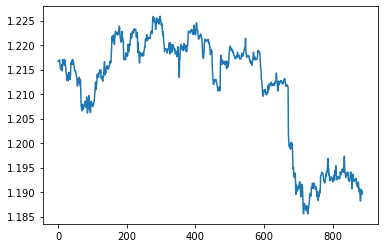

In [104]:
data.close.plot()

In [105]:
def BBANDS(df,n):
    MA= pd.Series(pd.Series.rolling(df['close'], n).mean())
    MSD=pd.Series(pd.Series.rolling(df['close'], n).std())
    b1=MA + (MSD*2)
    B1= pd.Series(b1, name = 'BollingerSuperior')
    df= df.join(B1)
    b2= MA - (MSD*2)
    B2= pd.Series(b2, name = 'BollingerInferior')
    df = df.join(B2)
    b3= MA
    B3= pd.Series(b3, name = 'BollingerM_')
    df = df.join(B3)
    return df

In [107]:
df = BBANDS(data,20)
df

,time,open,high,low,close,tick_volume,spread,real_volume,BollingerSuperior,BollingerInferior,BollingerM_
0,2021-05-07 17:00:00,1.21646,1.21708,1.21625,1.21671,28899,15,4334850000,NaN,NaN,NaN
1,2021-05-07 18:00:00,1.21671,1.21671,1.21612,1.21664,14470,13,2170500000,NaN,NaN,NaN
2,2021-05-09 19:00:00,1.21599,1.21707,1.21599,1.21661,1573,15,235950000,NaN,NaN,NaN
3,2021-05-09 20:00:00,1.21661,1.21740,1.21606,1.21668,12015,15,1802250000,NaN,NaN,NaN
4,2021-05-09 21:00:00,1.21668,1.21761,1.21668,1.21699,13583,15,2037450000,NaN,NaN,NaN
5,2021-05-09 22:00:00,1.21699,1.21700,1.21592,1.21608,29832,15,4474800000,NaN,NaN,NaN
6,2021-05-09 23:00:00,1.21608,1.21625,1.21538,1.21574,34122,15,5118300000,NaN,NaN,NaN
7,2021-05-10 00:00:00,1.21574,1.21602,1.21506,1.21508,26456,15,3968400000,NaN,NaN,NaN
8,2021-05-10 01:00:00,1.21508,1.21558,1.21504,1.21541,20433,15,3064950000,NaN,NaN,NaN
9,2021-05-10 02:00:00,1.21541,1.21566,1.21507,1.21508,16964,15,2544600000,NaN,NaN,NaN


In [108]:
df2 = df[['close','BollingerSuperior','BollingerInferior','BollingerM_']]

<AxesSubplot:>

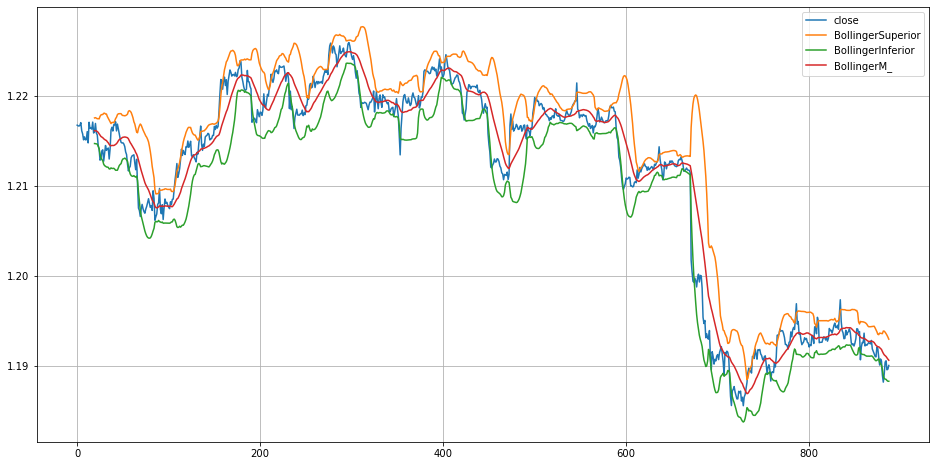

In [109]:
df2.plot(figsize = (16,8),grid=True)

In [110]:
a = df['BollingerSuperior']
b = df['BollingerInferior']

data.loc[(data['close'] < a) & (data['close'] > b), 'Comportamiento'] = 'Entre bandas'
data.loc[data['close'] <b, 'Comportamiento'] = 'Cruce de banda inferior'
data.loc[data['close'] >a, 'Comportamiento'] = 'Cruce de banda superior'

data.loc[(data['close'] < a) & (data['close'] > b), 'Recomendacion'] = '-'
data.loc[data['close'] <b, 'Recomendacion'] = 'Se recomienda comprar la accion.'
data.loc[data['close'] >a, 'Recomendacion'] = 'Se recomienda vender la accion'

data["Recomendacion"] = data["Recomendacion"].fillna("-")
data["Comportamiento"] = data["Comportamiento"].fillna("Sin informacion")

In [111]:
pd.set_option('display.max_rows', None)

In [112]:
data[['close','Comportamiento', 'Recomendacion']]

,close,Comportamiento,Recomendacion
0,1.21671,Sin informacion,-
1,1.21664,Sin informacion,-
2,1.21661,Sin informacion,-
3,1.21668,Sin informacion,-
4,1.21699,Sin informacion,-
5,1.21608,Sin informacion,-
6,1.21574,Sin informacion,-
7,1.21508,Sin informacion,-
8,1.21541,Sin informacion,-
9,1.21508,Sin informacion,-


In [119]:
def STO(df, nK, nD, nS=1):
    SOk = pd.Series((df['close'] - df['low'].rolling(nK).min())/(df['high'].rolling(nK).max() - df['low'].rolling(nK).min()), name = 'SOk'+str(nK) )
    SOd = pd.Series(SOk.ewm(ignore_na = False, span = nD, min_periods = nD -1, adjust = True).mean(), name = 'SOd'+str(nD))
    SOk = SOk.ewm(ignore_na = False, span = nS, min_periods = nS - 1 , adjust = True).mean()
    SOd = SOd.ewm(ignore_na = False, span = nS, min_periods = nS - 1 , adjust = True).mean()
    df = df.join(SOk)
    df = df.join(SOd)
    df['Recomendacion'] = 0
    df.loc[(((SOk < SOd) & (SOk.shift(1) > SOd.shift(1))) & (SOd > 0.8)),'Recomendacion'] = 'Vender'
    df.loc[(((SOk > SOd) & (SOk.shift(1) < SOd.shift(1))) & (SOd < 0.2)),'Recomendacion'] = 'Comprar'
    df.loc[ df['Recomendacion'] == 0, 'Recomendacion'] = '-'

    return df

In [120]:
df2 = STO(data, 14, 3)

In [122]:
import matplotlib.pyplot as plt

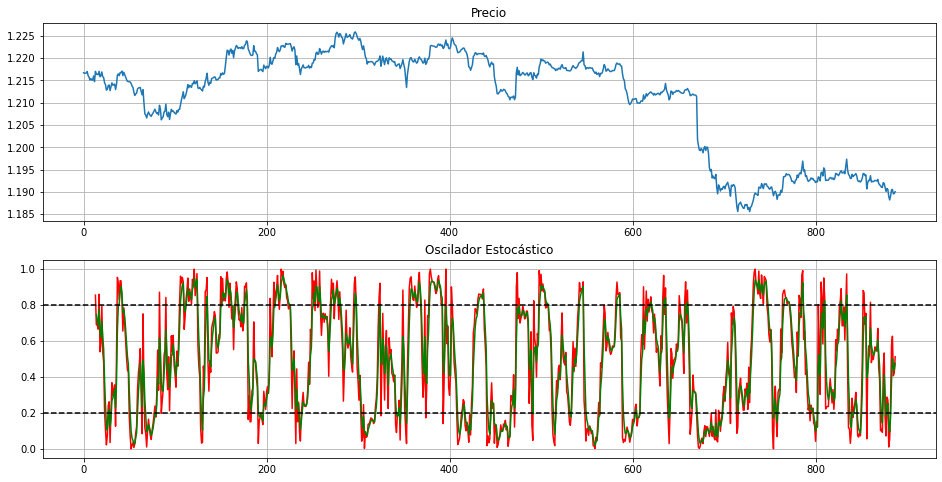

In [124]:
fig = plt.figure(figsize = (16,8))
ax1 = plt.subplot(211)
plt.plot(df2.close)
plt.grid(True)
plt.title('Precio')
ax2 = plt.subplot(212, sharex=ax1)
plt.plot(df2.SOk14, color = 'r')
plt.plot(df2.SOd3, color = 'g')
plt.axhline(y=0.8, color = 'k', linestyle = '--')
plt.axhline(y=0.2, color = 'k', linestyle = '--')
plt.title('Oscilador Estocástico')
plt.grid(True)
plt.show()

In [125]:
df2[['close', 'Recomendacion']]

,close,Recomendacion
0,1.21671,-
1,1.21664,-
2,1.21661,-
3,1.21668,-
4,1.21699,-
5,1.21608,-
6,1.21574,-
7,1.21508,-
8,1.21541,-
9,1.21508,-
